```
Target:
    > Modify model architecture by adding depth to channels,1X1 filters,reduce dropout

Results:
    > Parameters: 7.83k
    > Best Train Accuracy: 99.04 (10th Epoch)
    > Best Test Accuracy: 99.28 (11th Epoch),99.27(9th Epoch)
Analysis:
    The modified model test accuracy was ~99.2% while train accuracy was not improving above 99.04
```




# Import Libraries

In [16]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [17]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      #  transforms.RandomAffine(degrees=15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                      #  transforms.RandomErasing()
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [18]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [19]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model
Let's start with the model we first saw

In [22]:
import torch.nn.functional as F
dropout_value = 0.01

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3,bias=False),  
            nn.ReLU(),
            nn.BatchNorm2d(8),
            # nn.Dropout2d(dropout_value),

            nn.Conv2d(8, 16, 3,padding=1,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout2d(dropout_value),
        )
        self.pool1 = nn.MaxPool2d(2,2)
        self.trans1 = nn.Sequential(
            nn.Conv2d(16, 8, 1,bias=False),
            nn.ReLU(),
        )
        self.conv2 =  nn.Sequential(
            nn.Conv2d(8, 8, 3,bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(dropout_value),

            nn.Conv2d(8, 16, 3,bias=False),  
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout_value),

            nn.Conv2d(16, 24, 3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout2d(dropout_value), 
        )
        
        self.trans2 = nn.Sequential(
            nn.Conv2d(24, 24, 1,bias=False),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 24, 3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout2d(dropout_value),    
        )
        self.gap = nn.Sequential(
            nn.AvgPool2d(6)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(24, 16, 1,bias=False),nn.ReLU(),nn.BatchNorm2d(16))
        self.conv5 = nn.Sequential(nn.Conv2d(16,10,1,bias=False))

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        # x = self.conv3(x)
        x = self.gap(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # print(x.shape)
        x = x.view(-1,10)
        # x = self.fc(x)
        # print(x.shape)
        return F.log_softmax(x,dim=-1)



# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [23]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 26, 26]           1,152
              ReLU-5           [-1, 16, 26, 26]               0
       BatchNorm2d-6           [-1, 16, 26, 26]              32
         MaxPool2d-7           [-1, 16, 13, 13]               0
            Conv2d-8            [-1, 8, 13, 13]             128
              ReLU-9            [-1, 8, 13, 13]               0
           Conv2d-10            [-1, 8, 11, 11]             576
             ReLU-11            [-1, 8, 11, 11]               0
      BatchNorm2d-12            [-1, 8, 11, 11]              16
        Dropout2d-13            [-1, 8, 11, 11]               0
           Conv2d-14             [

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [24]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)
  train_losses.append(train_loss / len(train_loader))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [25]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.10275761038064957 Batch_id=468 Accuracy=91.11: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0804, Accuracy: 9770/10000 (97.70%)

EPOCH: 1


Loss=0.1109507605433464 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9835/10000 (98.35%)

EPOCH: 2


Loss=0.04996946081519127 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0520, Accuracy: 9845/10000 (98.45%)

EPOCH: 3


Loss=0.037601787596940994 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.006898983847349882 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:26<00:00, 17.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Loss=0.0679066851735115 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:26<00:00, 17.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.008961941115558147 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.018867144361138344 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.017718235030770302 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.017660070210695267 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.02801685966551304 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.010718464851379395 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:26<00:00, 17.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.02246980555355549 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:26<00:00, 17.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.07661829888820648 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:26<00:00, 17.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.03172140195965767 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:26<00:00, 17.80it/s]



Test set: Average loss: 0.0235, Accuracy: 9927/10000 (99.27%)



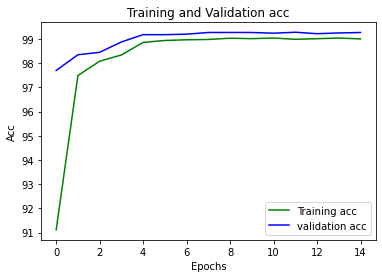

In [29]:
import matplotlib.pyplot as plt
% matplotlib inline
epochs = [x for x in range(0,15)]
plt.plot(epochs,train_acc, 'g', label='Training acc')
plt.plot(epochs,test_acc, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

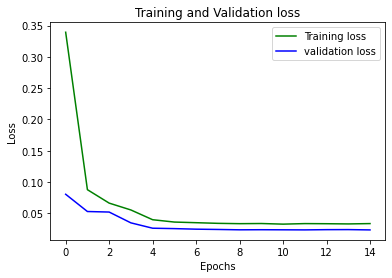

In [32]:
epochs = [x for x in range(0,15)]
plt.plot(epochs,train_losses, 'g', label='Training loss')
plt.plot(epochs,test_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()